In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from itertools import product
from ipywidgets import IntProgress
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

In [28]:
data = pd.read_csv('data_kaggle.csv')

In [29]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index(['Date'], inplace=True)
data['Promo'] = data['Promo'].fillna(0)
data.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
data['Regular_Price'] = data['Regular_Price'].ffill().bfill()
data.reset_index().set_index(['Date'], inplace=True)

# add actual price (promo price when promo occurred or regular price otherwise)

data['Actual_Price'] = data['Promo_Price'].combine_first(data['Regular_Price'])
data['Promo_percent'] = (1 - (data['Actual_Price'] / data['Regular_Price']))
data = data.drop('Promo_Price', axis=1)

data.reset_index(inplace=True)
data["weekday"] = data['Date'].dt.weekday
data["monthday"] = data['Date'].dt.day
data['is_weekend'] = data['weekday'].isin([5, 6]) * 1
data['month_period'] = 0
data.loc[data['monthday'] >= 15, 'month_period'] = 1

data.head()



,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,weekday,monthday,is_weekend,month_period
0,2015-01-01,1,1,0.0,22.0,163.78,163.78,0.0,3,1,0,0
1,2015-01-01,19,1,0.0,25.0,163.78,163.78,0.0,3,1,0,0
2,2015-01-01,39,2,0.0,3.0,135.78,135.78,0.0,3,1,0,0
3,2015-01-01,40,2,0.0,0.0,135.78,135.78,0.0,3,1,0,0
4,2015-01-01,18,1,0.0,13.0,163.78,163.78,0.0,3,1,0,0


In [ ]:
## test base feature

data['demand_expanding_mean'] = data.groupby(['Store_id', 'SKU_id'])['Demand'].expanding().mean().droplevel(['Store_id', 'SKU_id'])
data['demand_expanding_mean'] = data.groupby(['Store_id', 'SKU_id'])['demand_expanding_mean'].apply(lambda x: x.shift(1))



In [30]:
from scipy.signal import cwt, find_peaks_cwt, ricker, welch


def _get_length_sequences_where(x):
    if len(x) == 0:
        return [0]
    else:
        res = [len(list(group)) for value, group in itertools.groupby(x) if value == 1]
        return res if len(res) > 0 else [0]


def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.nanpercentile(x, n)

    percentile_.__name__ = 'perc%s' % n
    return percentile_


def variation(x):
    mean = x.mean()
    if mean != 0:
        return x.std() / mean
    else:
        return np.nan
    
def abs_energy(x):
    
    return np.nansum(x * x)

def absolute_sum_of_changes(x):
    
     return np.nansum(np.abs(np.diff(x)))
    
def count_above_mean(x):
    
    m = x.mean()
    return np.where(x > m)[0].size

def count_below_mean(x):

    m = x.mean()
    return np.where(x < m)[0].size


""" doesnt fit our code """
def count_above(t):
    def count_above_(x):
        return np.sum(x >= t) / len(x)
    
    count_above_.__name__ = 'count_above%s' % t
    return count_above_

""" doesnt fit our code """
def count_below(t):
    def count_below_(x):
        return np.sum(x <= t) / len(x)
    
    count_above_.__name__ = 'count_above%s' % t
    return count_above_mean

""" doesnt fit our task, what does index mean for every group? """
def first_location_of_minimum(x):
    
    return np.argmin(x) / len(x) if len(x) > 0 else np.NaN

""" doesnt fit our task, what does index mean for every group? """
def first_location_of_maximum(x):
    return np.argmax(x) / len(x) if len(x) > 0 else np.NaN


def longest_strike_below_mean(x):
    
    return np.max(_get_length_sequences_where(x < x.mean())) if x.size > 0 else 0

def longest_strike_above_mean(x):

    return np.max(_get_length_sequences_where(x > x.mean())) if x.size > 0 else 0


def mean_second_derivative_central(x):

    return (x[-1] - x[-2] - x[1] + x[0]) / (2 * (len(x) - 2)) if len(x) > 2 else np.NaN

## не посчиталось
def number_crossing_m(x):
    m = x.mean()
    positive = x > m
    return np.where(np.diff(positive))[0].size

## не посчиталось
def number_cwt_peaks(n):    
    def number_cwt_peaks_(x):

        return len(
            find_peaks_cwt(vector=x, widths=np.array(list(range(1, n + 1))), wavelet=ricker)
        )
    
    return number_cwt_peaks_

## не посчиталось
def range_count(x):
    
    min_ = x.mean() - 3 * x.std()
    max_ = x.mean() + 3 * x.std()
    return np.sum((x >= min_) & (x < max_))


def ratio_beyond_r_sigma(r):

    def ratio_beyond_r_sigma_(x):
        return np.sum(np.abs(x - x.mean()) > r * x.std()) / x.size
    
    return ratio_beyond_r_sigma_

def root_mean_square(x):
    
    return np.sqrt(np.square(x).mean()) if len(x) > 0 else np.NaN

def symmetry_looking(r):

    def symmetry_looking_(x):
        mean_median_difference = np.abs(x.mean() - x.median())
        max_min_difference = x.max() - x.min()
        return mean_median_difference < (r * max_min_difference)
    
    return symmetry_looking_

## не считал
def benford_correlation(x):

    x = np.array(
        [int(str(np.format_float_scientific(i))[:1]) for i in np.abs(np.nan_to_num(x))]
    )

    benford_distribution = np.array([np.log10(1 + 1 / n) for n in range(1, 10)])
    data_distribution = np.array([(x == n).mean() for n in range(1, 10)])

    return np.corrcoef(benford_distribution, data_distribution)[0, 1]

## не считал
def cid_ce(x):

    x = np.diff(x)
    return np.sqrt(np.nansum(x * x))



In [31]:
## add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)

    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=np.nan)

    results.index.rename(date_col, inplace=True)

    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col).agg(
        preagg_method)[target_cols].reset_index()

    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
        fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                    axis=1).reset_index()

    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):

    lf_df = lf_df_filled.groupby(
        level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def lagged_features(
        data,
        target_cols=['Demand'],
        id_cols=['SKU_id'],
        date_col='Date',
        lags=[7, 14, 21, 28],
        windows=['7D', '14D', '28D', '56D'],
        preagg_methods=['mean'],  # ['mean', 'count']
        agg_methods=['mean', 'median', percentile(10), percentile(90)],
        dynamic_filters=['weekday'],
        static_filters=None,
        ewm_params={}
):
    '''Calculate lagged features '''
    ''' data - dataframe with default index
        target_cols - column names to calculate lags
        id_cols - key columns
        lags - lag values(days)
        windows - list of windows(string type), calculation is performed within time range length of window
        preagg_methods - applied methods before rolling
        agg_methods - method of aggregation, e.g. 'mean', 'median', percentile, etc.
        dynamic_filters - column names of filter
        static_filters - ...
        ewm_params - alpha values for each filter_col based on groupping granularity ewm method
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = group_col = [filter_col] + id_cols + [date_col]
        for lag in lags:
            for preagg in preagg_methods:
                data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                    target_cols, preagg)

                ## add ewm features
                for alpha in ewm_params.get(filter_col, []):
                    ewm_filled = calc_ewm(data_preag_filled, group_col,
                                          date_col, alpha)
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                        format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df,
                                      ewm.rename(columns=new_names),
                                      how='left',
                                      on=group_col)

                for w in windows:
                    for method in agg_methods:
                        rolling_filled = calc_rolling(data_preag_filled,
                                                      group_col, date_col,
                                                      method, w)

                        ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                        rolling = shift(rolling_filled, group_col, date_col,
                                        lag)

                        method_name = method.__name__ if type(
                            method) != str else method

                        new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                        out_df = pd.merge(out_df,
                                          rolling.rename(columns=new_names),
                                          how='left',
                                          on=group_col)
                        progress.value += 1

    return out_df

In [32]:
target_cols = ['Demand']
id_cols = ['SKU_id', 'Store_id']
date_col = 'Date'
built_in_funcs = [pd.Series.kurtosis, pd.Series.skew]


data_lagged_features = lagged_features(data 
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [21]
                    , windows = ['14D', '28D']
                    , preagg_methods = ['mean'] # ['mean', 'count']
                    , agg_methods = ['mean']
                    , dynamic_filters = ['Promo']
                    , static_filters=[]
                    , ewm_params={'weekday': [], 'Promo': []}
                    )

data_lagged_features


IntProgress(value=0, max=2)

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,weekday,monthday,is_weekend,month_period,Demand_lag21d_w14D_keySKU_id_Store_id_preagmean_agmean_Promo_dynamic_rolling,Demand_lag21d_w28D_keySKU_id_Store_id_preagmean_agmean_Promo_dynamic_rolling
0,2015-01-01,1,1,0.0,22.0,163.78,163.78,0.000000,3,1,0,0,NaN,NaN
1,2015-01-01,53,1,0.0,3.0,163.78,163.78,0.000000,3,1,0,0,NaN,NaN
2,2015-01-01,54,1,0.0,6.0,163.78,163.78,0.000000,3,1,0,0,NaN,NaN
3,2015-01-01,49,1,0.0,6.0,163.78,163.78,0.000000,3,1,0,0,NaN,NaN
4,2015-01-01,55,1,0.0,16.0,163.78,163.78,0.000000,3,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92881,2016-06-19,92,2,0.0,NaN,133.06,133.06,0.000000,6,19,1,1,0.000000,0.214286
92882,2016-06-19,66,1,1.0,NaN,134.96,125.04,0.073503,6,19,1,1,512.500000,512.500000
92883,2016-06-19,30,1,1.0,NaN,134.96,125.04,0.073503,6,19,1,1,348.666667,348.666667
92884,2016-06-19,76,1,1.0,NaN,134.96,125.04,0.073503,6,19,1,1,850.833333,850.833333


<AxesSubplot:title={'center':'demand_expanding_mean'}, xlabel='Date'>

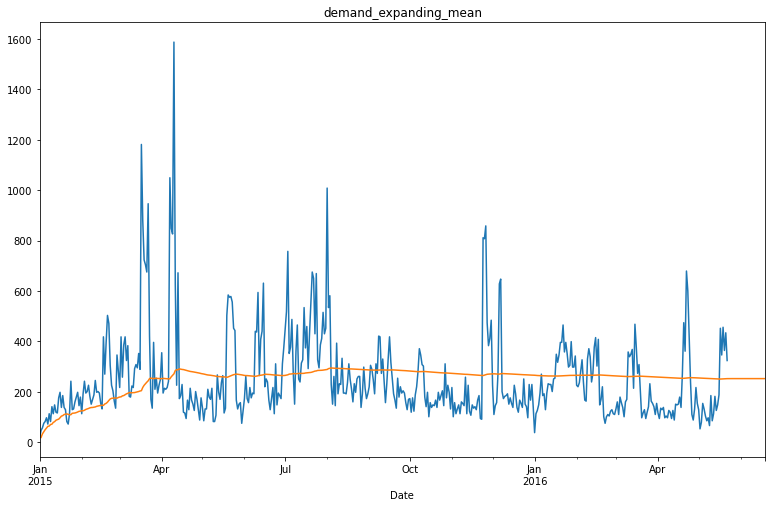

In [294]:
f = 'demand_expanding_mean'
store = 10
sku = 1

plt.figure(figsize=(13, 8))
plt.title(f)
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')['Demand'].plot()
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot()


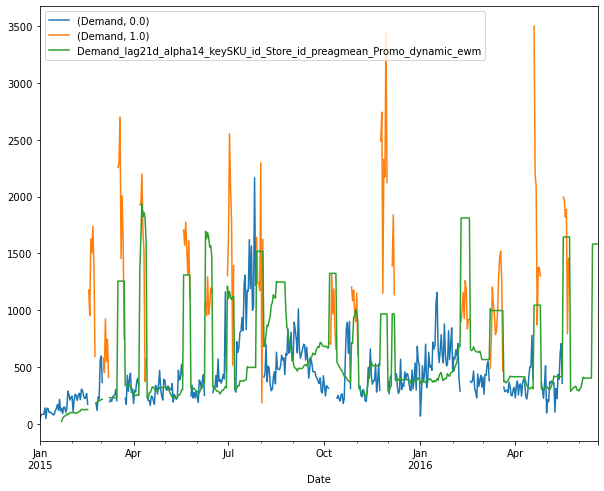

In [251]:
f = 'Demand_lag21d_alpha14_keySKU_id_Store_id_preagmean_Promo_dynamic_ewm'
store = 2
sku = 1

data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)]\
[['Demand', 'Promo', 'Date']].pivot(index='Date', columns='Promo').plot(figsize=(10, 8))
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot(label=f)
plt.legend()



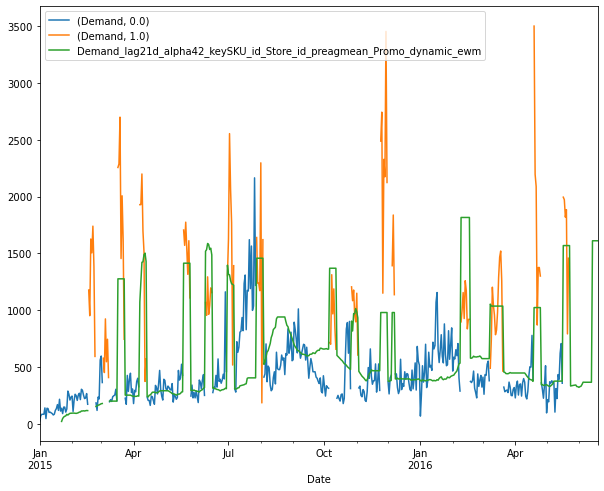

In [252]:
f = 'Demand_lag21d_alpha42_keySKU_id_Store_id_preagmean_Promo_dynamic_ewm'
store = 2
sku = 1

data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)]\
[['Demand', 'Promo', 'Date']].pivot(index='Date', columns='Promo').plot(figsize=(10, 8))
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot(label=f)
plt.legend()



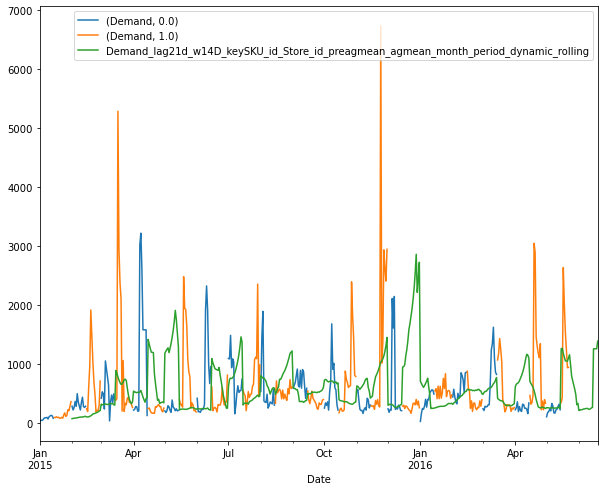

In [321]:
f = 'Demand_lag21d_w14D_keySKU_id_Store_id_preagmean_agmean_month_period_dynamic_rolling'
store = 5
sku = 1

data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)]\
[['Demand', 'month_period', 'Date']].pivot(index='Date', columns='month_period').plot(figsize=(10, 8))
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot(label=f)
plt.legend()



<AxesSubplot:title={'center':'Demand_lag21d_alpha42_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm'}, xlabel='Date'>

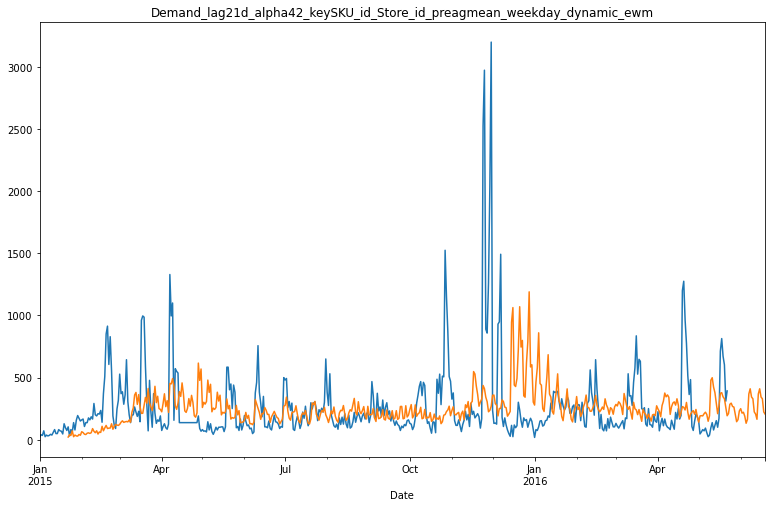

In [298]:
f = 'Demand_lag21d_alpha14_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm'
store = 1
sku = 1

plt.figure(figsize=(13, 8))
plt.title(f)
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')['Demand'].plot()
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot()



<AxesSubplot:title={'center':'Demand_lag21d_alpha42_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm'}, xlabel='Date'>

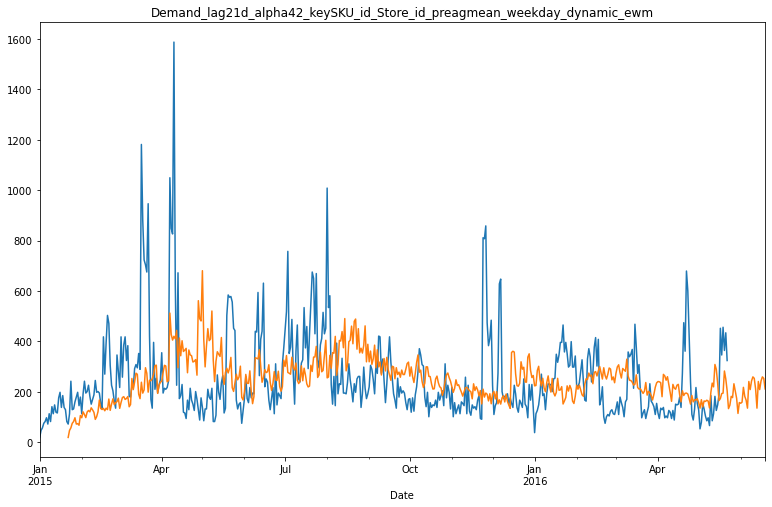

In [293]:
f = 'Demand_lag21d_alpha42_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm'
store = 10
sku = 1

plt.figure(figsize=(13, 8))
plt.title(f)
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')['Demand'].plot()
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot()



KeyError: 'Demand_lag21d_w14D_keySKU_id_Store_id_preagmean_agabs_energy_Promo_dynamic_rolling'

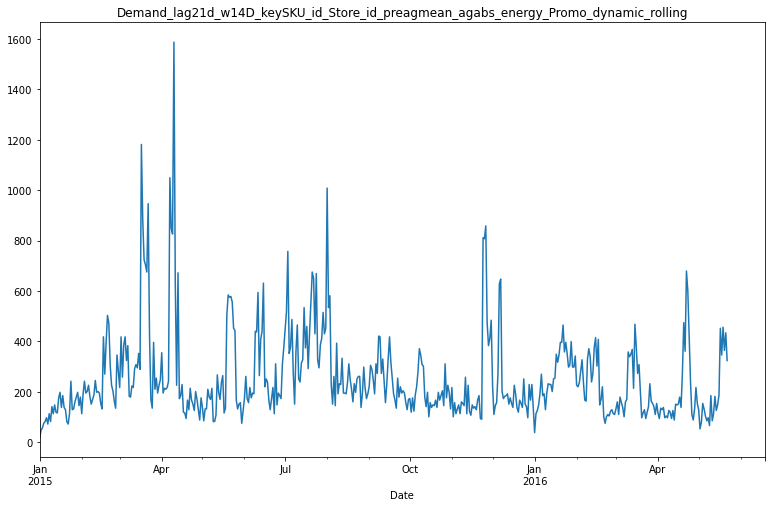

In [381]:
f = 'Demand_lag21d_w14D_keySKU_id_Store_id_preagmean_agabs_energy_Promo_dynamic_rolling'
store = 10
sku = 1

plt.figure(figsize=(13, 8))
plt.title(f)
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')['Demand'].plot()
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot()



<AxesSubplot:title={'center':'Demand_lag21d_w14D_keySKU_id_Store_id_preagmean_agroot_mean_square_Promo_dynamic_rolling'}, xlabel='Date'>

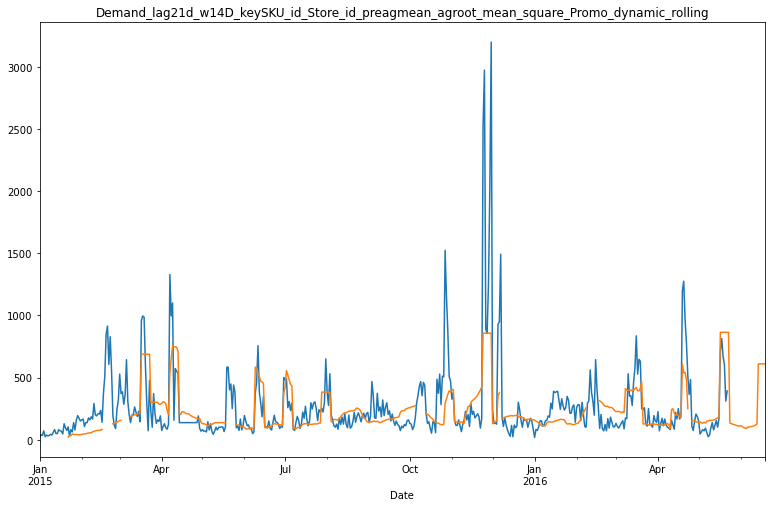

In [429]:
f = 'Demand_lag21d_w14D_keySKU_id_Store_id_preagmean_agroot_mean_square_Promo_dynamic_rolling'
store = 1
sku = 1

plt.figure(figsize=(13, 8))
plt.title(f)
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')['Demand'].plot()
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot()



In [ ]:
upload
-->data
model1
model2
model3
model4
model5 --> prediction